# Capstone Project 1: MuscleHub AB Test

## Step 1: Get started with SQL

Like most businesses, Janet keeps her data in a SQL database.  Normally, you'd download the data from her database to a csv file, and then load it into a Jupyter Notebook using Pandas.

For this project, you'll have to access SQL in a slightly different way.  You'll be using a special Codecademy library that lets you type SQL queries directly into this Jupyter notebook.  You'll have pass each SQL query as an argument to a function called `sql_query`.  Each query will return a Pandas DataFrame.  Here's an example:

In [8]:
# This import only needs to happen once, at the beginning of the notebook
from codecademySQL import sql_query

PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'example.db'

In [ ]:
# Here's an example of a query that just displays some data
sql_query('''
SELECT *
FROM visits
LIMIT 5
''')

In [ ]:
# Here's an example where we save the data to a DataFrame
df = sql_query('''
SELECT *
FROM applications
LIMIT 5
''')

## Step 2: Get your dataset

Let's get started!

Janet of MuscleHub has a SQLite database, which contains several tables that will be helpful to you in this investigation:
- `visits` contains information about potential gym customers who have visited MuscleHub
- `fitness_tests` contains information about potential customers in "Group A", who were given a fitness test
- `applications` contains information about any potential customers (both "Group A" and "Group B") who filled out an application.  Not everyone in `visits` will have filled out an application.
- `purchases` contains information about customers who purchased a membership to MuscleHub.

Use the space below to examine each table.

In [ ]:
# Examine visits here
sql_query('''
SELECT *
FROM visits
LIMIT 5
''')

In [ ]:
# Examine fitness_tests here
sql_query('''
SELECT *
FROM fitness_tests
LIMIT 5
''')

In [ ]:
# Examine applications here
sql_query('''
SELECT *
FROM applications
LIMIT 5
''')

In [ ]:
# Examine purchases here
sql_query('''
SELECT *
FROM purchases
LIMIT 5
''')

We'd like to download a giant DataFrame containing all of this data.  You'll need to write a query that does the following things:

1. Not all visits in  `visits` occurred during the A/B test.  You'll only want to pull data where `visit_date` is on or after `7-1-17`.

2. You'll want to perform a series of `LEFT JOIN` commands to combine the four tables that we care about.  You'll need to perform the joins on `first_name`, `last_name`, and `email`.  Pull the following columns:


- `visits.first_name`
- `visits.last_name`
- `visits.gender`
- `visits.email`
- `visits.visit_date`
- `fitness_tests.fitness_test_date`
- `applications.application_date`
- `purchases.purchase_date`

Save the result of this query to a variable called `df`.

Hint: your result should have 5004 rows.  Does it?

In [ ]:
df = sql_query('''
SELECT visits.first_name,
       visits.last_name,
       visits.visit_date,
       fitness_tests.fitness_test_date,
       applications.application_date,
       purchases.purchase_date
FROM visits
LEFT JOIN fitness_tests
    ON fitness_tests.first_name = visits.first_name
    AND fitness_tests.last_name = visits.last_name
    AND fitness_tests.email = visits.email
LEFT JOIN applications
    ON applications.first_name = visits.first_name
    AND applications.last_name = visits.last_name
    AND applications.email = visits.email
LEFT JOIN purchases
    ON purchases.first_name = visits.first_name
    AND purchases.last_name = visits.last_name
    AND purchases.email = visits.email
WHERE visits.visit_date >= '7-1-17'
''')

## Step 3: Investigate the A and B groups

We have some data to work with! Import the following modules so that we can start doing analysis:
- `import pandas as pd`
- `from matplotlib import pyplot as plt`

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt

We're going to add some columns to `df` to help us with our analysis.

Start by adding a column called `ab_test_group`.  It should be `A` if `fitness_test_date` is not `None`, and `B` if `fitness_test_date` is `None`.

In [ ]:
df['ab_test_group'] = df.fitness_test_date.apply(lambda x:
                                                'A' if pd.notnull(x) else 'B')

Let's do a quick sanity check that Janet split her visitors such that about half are in A and half are in B.

Start by using `groupby` to count how many users are in each `ab_test_group`.  Save the results to `ab_counts`.

In [ ]:
ab_counts = df.groupby('ab_test_group').first_name.count().reset_index()
ab_counts

We'll want to include this information in our presentation.  Let's create a pie cart using `plt.pie`.  Make sure to include:
- Use `plt.axis('equal')` so that your pie chart looks nice
- Add a legend labeling `A` and `B`
- Use `autopct` to label the percentage of each group
- Save your figure as `ab_test_pie_chart.png`

In [ ]:
plt.pie(ab_counts.first_name.values, labels=['A', 'B'], autopct='%0.2f%%')
plt.axis('equal')
plt.show()
plt.savefig('ab_test_pie_chart.png')

## Step 4: Who picks up an application?

Recall that the sign-up process for MuscleHub has several steps:
1. Take a fitness test with a personal trainer (only Group A)
2. Fill out an application for the gym
3. Send in their payment for their first month's membership

Let's examine how many people make it to Step 2, filling out an application.

Start by creating a new column in `df` called `is_application` which is `Application` if `application_date` is not `None` and `No Application`, otherwise.

In [11]:
df['is_application'] = df.application_date.apply(lambda x: 'Application'
                                                  if pd.notnull(x) else 'No Application')

NameError: name 'df' is not defined

Now, using `groupby`, count how many people from Group A and Group B either do or don't pick up an application.  You'll want to group by `ab_test_group` and `is_application`.  Save this new DataFrame as `app_counts`

In [ ]:
app_counts = df.groupby(['ab_test_group', 'is_application'])\
               .first_name.count().reset_index()

We're going to want to calculate the percent of people in each group who complete an application.  It's going to be much easier to do this if we pivot `app_counts` such that:
- The `index` is `ab_test_group`
- The `columns` are `is_application`
Perform this pivot and save it to the variable `app_pivot`.  Remember to call `reset_index()` at the end of the pivot!

In [ ]:
app_pivot = app_counts.pivot(columns='is_application',
                            index='ab_test_group',
                            values='first_name')\
            .reset_index()
app_pivot

Define a new column called `Total`, which is the sum of `Application` and `No Application`.

In [ ]:
app_pivot['Total'] = app_pivot.Application + app_pivot['No Application']

Calculate another column called `Percent with Application`, which is equal to `Application` divided by `Total`.

In [ ]:
app_pivot['Percent with Application'] = app_pivot.Application / app_pivot.Total
app_pivot

It looks like more people from Group B turned in an application.  Why might that be?

We need to know if this difference is statistically significant.

Choose a hypothesis tests, import it from `scipy` and perform it.  Be sure to note the p-value.
Is this result significant?

In [ ]:
from scipy.stats import chi2_contingency

contingency = [[250, 2254], [325, 2175]]
chi2_contingency(contingency)

## Step 4: Who purchases a membership?

Of those who picked up an application, how many purchased a membership?

Let's begin by adding a column to `df` called `is_member` which is `Member` if `purchase_date` is not `None`, and `Not Member` otherwise.

In [ ]:
df['is_member'] = df.purchase_date.apply(lambda x: 'Member' if pd.notnull(x) else 'Not Member')

Now, let's create a DataFrame called `just_apps` the contains only people who picked up an application.

In [ ]:
just_apps = df[df.is_application == 'Application']

Great! Now, let's do a `groupby` to find out how many people in `just_apps` are and aren't members from each group.  Follow the same process that we did in Step 4, including pivoting the data.  You should end up with a DataFrame that looks like this:

|is_member|ab_test_group|Member|Not Member|Total|Percent Purchase|
|-|-|-|-|-|-|
|0|A|?|?|?|?|
|1|B|?|?|?|?|

Save your final DataFrame as `member_pivot`.

In [ ]:
member_count = just_apps.groupby(['ab_test_group', 'is_member'])\
                 .first_name.count().reset_index()
member_pivot = member_count.pivot(columns='is_member',
                                  index='ab_test_group',
                                  values='first_name')\
                           .reset_index()

member_pivot['Total'] = member_pivot.Member + member_pivot['Not Member']
member_pivot['Percent Purchase'] = member_pivot.Member / member_pivot.Total
member_pivot

It looks like people who took the fitness test were more likely to purchase a membership **if** they picked up an application.  Why might that be?

Just like before, we need to know if this difference is statistically significant.  Choose a hypothesis tests, import it from `scipy` and perform it.  Be sure to note the p-value.
Is this result significant?

In [ ]:
contingency = [[200, 50], [250, 75]]
chi2_contingency(contingency)

Previously, we looked at what percent of people **who picked up applications** purchased memberships.  What we really care about is what percentage of **all visitors** purchased memberships.  Return to `df` and do a `groupby` to find out how many people in `df` are and aren't members from each group.  Follow the same process that we did in Step 4, including pivoting the data.  You should end up with a DataFrame that looks like this:

|is_member|ab_test_group|Member|Not Member|Total|Percent Purchase|
|-|-|-|-|-|-|
|0|A|?|?|?|?|
|1|B|?|?|?|?|

Save your final DataFrame as `final_member_pivot`.

In [10]:
final_member_count = df.groupby(['ab_test_group', 'is_member'])\
                 .first_name.count().reset_index()
final_member_pivot = final_member_count.pivot(columns='is_member',
                                  index='ab_test_group',
                                  values='first_name')\
                           .reset_index()

final_member_pivot['Total'] = final_member_pivot.Member + final_member_pivot['Not Member']
final_member_pivot['Percent Purchase'] = final_member_pivot.Member / final_member_pivot.Total
final_member_pivot

NameError: name 'df' is not defined

Previously, when we only considered people who had **already picked up an application**, we saw that there was no significant difference in membership between Group A and Group B.

Now, when we consider all people who **visit MuscleHub**, we see that there might be a significant different in memberships between Group A and Group B.  Perform a significance test and check.

In [ ]:
contingency = [[200, 2304], [250, 2250]]
chi2_contingency(contingency)

## Step 5: Summarize the acquisition funel with a chart

We'd like to make a bar chart for Janet that shows the difference between Group A (people who were given the fitness test) and Group B (people who were not given the fitness test) at each state of the process:
- Percent of visitors who apply
- Percent of applicants who purchase a membership
- Percent of visitors who purchase a membership

Create one plot for **each** of the three sets of percentages that you calculated in `app_pivot`, `member_pivot` and `final_member_pivot`.  Each plot should:
- Label the two bars as `Fitness Test` and `No Fitness Test`
- Make sure that the y-axis ticks are expressed as percents (i.e., `5%`)
- Have a title

In [ ]:
# Percent of Visitors who Apply
ax = plt.subplot()
plt.bar(range(len(app_pivot)),
       app_pivot['Percent with Application'].values)
ax.set_xticks(range(len(app_pivot)))
ax.set_xticklabels(['Fitness Test', 'No Fitness Test'])
ax.set_yticks([0, 0.05, 0.10, 0.15, 0.20])
ax.set_yticklabels(['0%', '5%', '10%', '15%', '20%'])
plt.show()
plt.savefig('percent_visitors_apply.png')

In [ ]:
# Percent of Applicants who Purchase
ax = plt.subplot()
plt.bar(range(len(member_pivot)),
       member_pivot['Percent Purchase'].values)
ax.set_xticks(range(len(app_pivot)))
ax.set_xticklabels(['Fitness Test', 'No Fitness Test'])
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax.set_yticklabels(['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'])
plt.show()
plt.savefig('percent_apply_purchase.png')

NameError: name 'final_member_pivot' is not defined

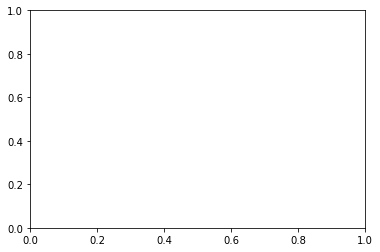

In [9]:
# Percent of Visitors who Purchase
import matplotlib.pyplot as plt
ax = plt.subplot()
plt.bar(range(len(final_member_pivot)),
       final_member_pivot['Percent Purchase'].values)
ax.set_xticks(range(len(app_pivot)))
ax.set_xticklabels(['Fitness Test', 'No Fitness Test'])
ax.set_yticks([0, 0.05, 0.10, 0.15, 0.20])
ax.set_yticklabels(['0%', '5%', '10%', '15%', '20%'])
plt.show()
plt.savefig('percent_visitors_purchase.png')